# VGG16

### Loading Libraries

In [27]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import image_dataset_from_directory

from glob import glob
import math

### Loading the Data

In [20]:
data_dir = 'lung_colon_image_set/'

folders = glob(data_dir + '/*')
print(folders)

images = glob(data_dir + '/*/*.jpeg')
print('No. of Images: ', len(images))

['lung_colon_image_set\\colon_aca', 'lung_colon_image_set\\colon_n', 'lung_colon_image_set\\lung_aca', 'lung_colon_image_set\\lung_n', 'lung_colon_image_set\\lung_scc']
No. of Images:  25000


### Plotting Sample Data

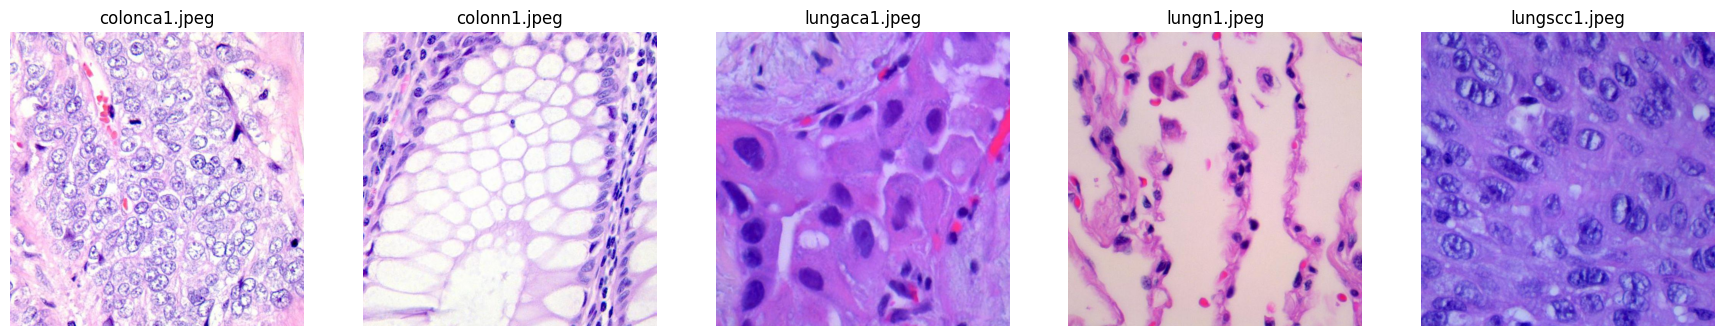

In [21]:
sample_imgs = ['lung_colon_image_set/colon_aca/colonca1.jpeg', 'lung_colon_image_set/colon_n/colonn1.jpeg',
               'lung_colon_image_set/lung_aca/lungaca1.jpeg', 'lung_colon_image_set/lung_n/lungn1.jpeg',
               'lung_colon_image_set/lung_scc/lungscc1.jpeg']


plt.figure(figsize=(22, 8)) 
n = 1

for i in sample_imgs:
    plt.subplot(1, 5, n)
    n += 1
    plt.title(i.split('/')[2])
    plt.imshow(image.load_img(i))
    plt.axis('off')
plt.show()

### Preprocessing the Data

In [22]:
img_path = 'lung_colon_image_set/colon_aca/colonca1.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
#img_array = preprocess_input(img_array)

### Splitting into Train-Test-Validation Sets

In [23]:
train_data = image_dataset_from_directory(data_dir,
                                          validation_split=0.3,
                                          subset="training",
                                          seed=21,
                                          image_size=(224, 224),
                                          batch_size=128)

Found 25000 files belonging to 5 classes.
Using 17500 files for training.


In [24]:
test_val_data = image_dataset_from_directory(data_dir,
                                             validation_split=0.3,
                                             subset="validation",
                                             seed=21,
                                             image_size=(224, 224),
                                             batch_size=128)

Found 25000 files belonging to 5 classes.
Using 7500 files for validation.


In [32]:
test_data = test_val_data.take(math.ceil(len(test_val_data) * 0.5))
val_data = test_val_data.take(math.floor(len(test_val_data) * 0.5))

In [35]:
class_names = train_data.class_names
print(class_names)

['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']


In [ ]:
for image_batch, labels_batch in train_data:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(128, 224, 224, 3)
(128,)


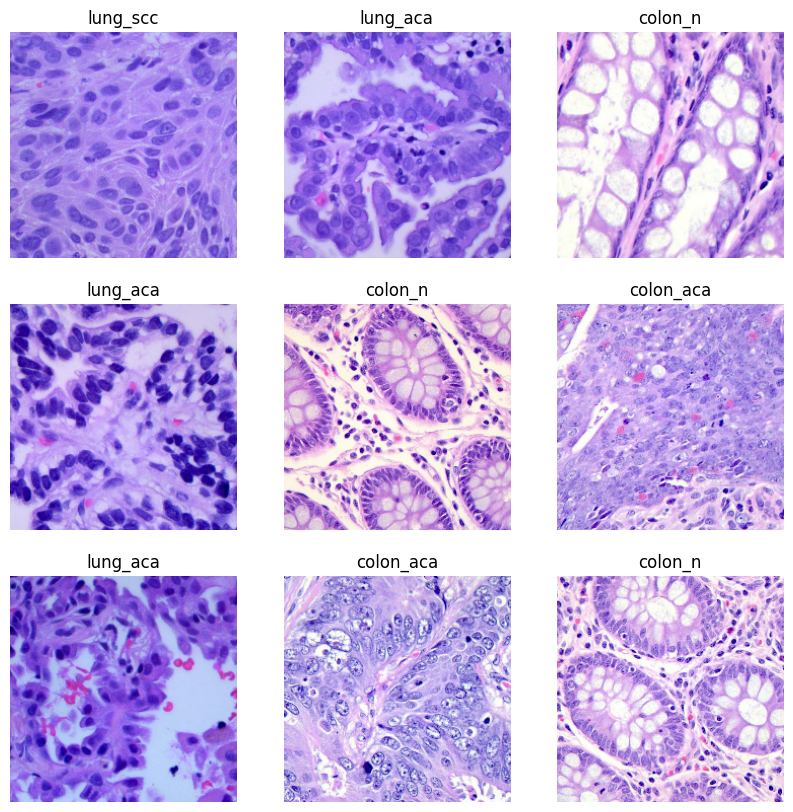

In [37]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")